In [4]:
#pip install imblearn torch torchvision torchtext torchdata tensorflow

In [5]:
#pip install tensorflow-gpu==2.10

In [6]:
#pip install numpy==1.24.4

In [7]:
import tensorflow as tf

# This will return a list of available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Or simply check if at least one GPU is available
print("Is GPU available?", len(gpus) > 0)

GPUs available: []
Is GPU available? False


In [8]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [9]:
import torch
torch.cuda.is_available()

True

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import os
import sys


In [11]:
# Load the datasets
wadi_attack_cleaned_path = 'WADI_cleaned_for_modeling.csv'

# Read the CSV files into pandas DataFrames
df = pd.read_csv(wadi_attack_cleaned_path, header=0)

# Display the first few rows of each dataframe to understand the structure of the data
df.columns = df.columns.str.strip()
df.head()

,Timestamp,Day,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,"Attack LABLE (1:No Attack, -1:Attack)"
0,2017-10-09 00:00:00,2017-10-09,1.0,10/09/2017,12:00 am,164.210,0.529486,11.9972,482.480,0.331167,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,1
1,2017-10-09 00:00:00,2017-10-09,14425.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
2,2017-10-09 00:00:00,2017-10-09,14424.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
3,2017-10-09 00:00:00,2017-10-09,14423.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1
4,2017-10-09 00:00:00,2017-10-09,14422.0,10/09/2017,12:00 am,169.076,0.643471,11.9182,471.703,0.305731,...,1.0,1.0,1.0,1.0,1.0,1.0,60.0771,1.0,0.30,1


In [12]:
# Step 2: Identify label column
df.columns = df.columns.str.strip()
label_col = [col for col in df.columns if 'Attack' in col][0]  # dynamic detection
print(f"Detected label column: {label_col}")

# Step 3: Drop non-feature columns
drop_cols = ['Row', 'Date', 'Time', 'Timestamp', label_col]
features = df.drop(columns=drop_cols, errors='ignore')
features = features.select_dtypes(include=['float64', 'int64'])  # Keep only numeric columns
labels = df[label_col]

# Step 4: Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

# Step 5: Train-test split (80/20), stratify to balance attack/normal
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, labels, test_size=0.2, stratify=labels, random_state=42
)

# Shape summary
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Label distribution in train:\n{pd.Series(y_train).value_counts()}")
print(f"Label distribution in test:\n{pd.Series(y_test).value_counts()}")

Detected label column: Attack LABLE (1:No Attack, -1:Attack)


c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Train shape: (138240, 127), Test shape: (34561, 127)
Label distribution in train:
Attack LABLE (1:No Attack, -1:Attack)
 1    130258
-1      7982
Name: count, dtype: int64
Label distribution in test:
Attack LABLE (1:No Attack, -1:Attack)
 1    32566
-1     1995
Name: count, dtype: int64


# Modelling

📊 Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1995
           1       1.00      1.00      1.00     32566

    accuracy                           1.00     34561
   macro avg       1.00      1.00      1.00     34561
weighted avg       1.00      1.00      1.00     34561



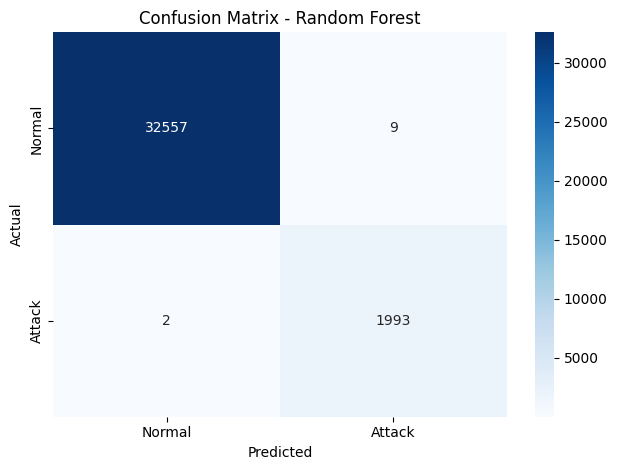

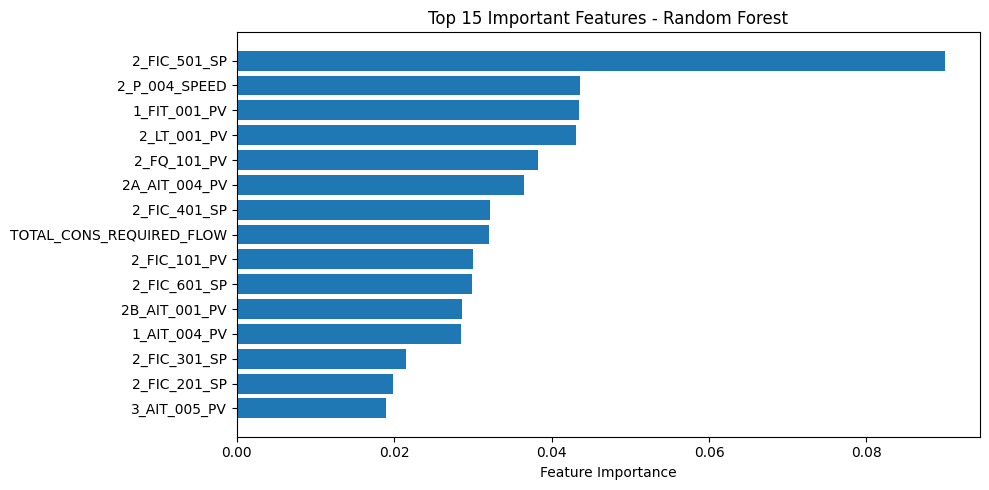

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Step 2: Predict
y_pred = rf_model.predict(X_test)

# Step 3: Evaluate
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Step 5: Feature Importance
# Plot top 15 features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - Random Forest')
plt.tight_layout()
plt.show()


🔹 Baseline Random Forest Performance:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1995
           1       1.00      1.00      1.00     32566

    accuracy                           1.00     34561
   macro avg       1.00      1.00      1.00     34561
weighted avg       1.00      1.00      1.00     34561



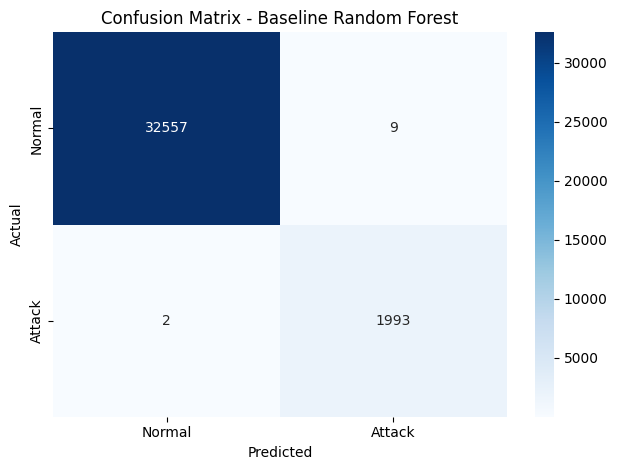

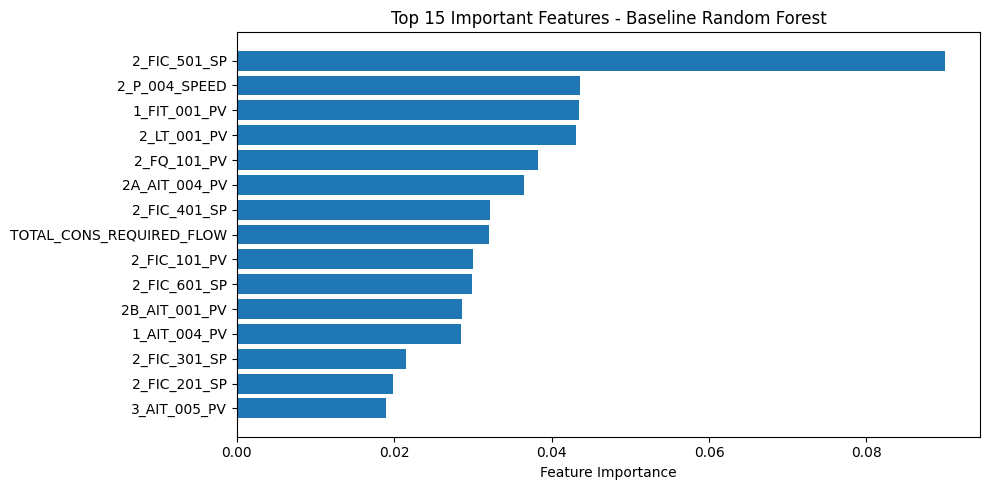

Model saved to random_forest_model.pkl


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Basic model
rf_basic = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_basic.fit(X_train, y_train)

# Predict
y_pred_basic = rf_basic.predict(X_test)

# Evaluate
print("🔹 Baseline Random Forest Performance:")
print(classification_report(y_test, y_pred_basic))
# confusion Matix
cm_basic = confusion_matrix(y_test, y_pred_basic, labels=[1, -1])
sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Baseline Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Feature Importance
importances_basic = rf_basic.feature_importances_
indices_basic = np.argsort(importances_basic)[-15:]
plt.figure(figsize=(10, 5))
plt.barh(range(len(indices_basic)), importances_basic[indices_basic], align='center')
plt.yticks(range(len(indices_basic)), [features.columns[i] for i in indices_basic])
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - Baseline Random Forest')
plt.tight_layout()
plt.show()

# Step 6: Save the model

import joblib
# Save the model to a file
model_filename = 'random_forest_model.pkl'
joblib.dump(rf_model, model_filename)
print(f"Model saved to {model_filename}")



Fitting 2 folds for each of 8 candidates, totalling 16 fits
🔹 Tuned Random Forest Performance:
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1995
           1       1.00      1.00      1.00     32566

    accuracy                           1.00     34561
   macro avg       1.00      1.00      1.00     34561
weighted avg       1.00      1.00      1.00     34561



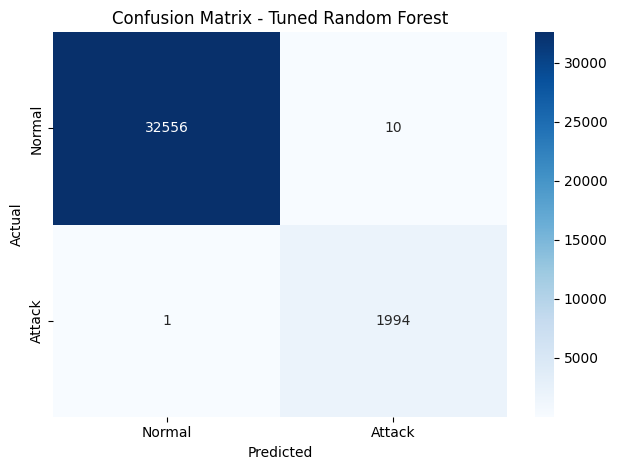

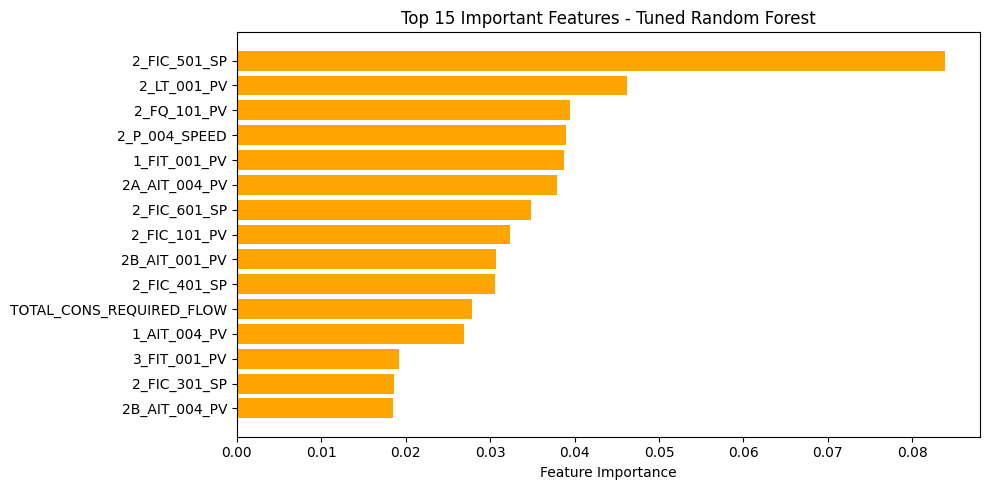

Model saved to tuned_best_random_forest_model.pkl


In [15]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

# Grid Search
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=2, n_jobs=1, verbose=1,
    scoring='f1_macro'
)
rf_grid.fit(X_train, y_train)

# Best model
best_rf = rf_grid.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

# Evaluation
print("🔹 Tuned Random Forest Performance:")
print("Best Params:", rf_grid.best_params_)
print(classification_report(y_test, y_pred_tuned))
# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned, labels=[1, -1])
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Feature Importance
importances_tuned = best_rf.feature_importances_
indices_tuned = np.argsort(importances_tuned)[-15:]
plt.figure(figsize=(10, 5))
plt.barh(range(len(indices_tuned)), importances_tuned[indices_tuned], color='orange', align='center')
plt.yticks(range(len(indices_tuned)), [features.columns[i] for i in indices_tuned])
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - Tuned Random Forest')
plt.tight_layout()
plt.show()

# Save the model
import joblib
model_path = 'tuned_best_random_forest_model.pkl'
joblib.dump(best_rf, model_path)
print(f"Model saved to {model_path}")


In [16]:
# Save the model
import joblib
model_path = 'tuned_best_random_forest_model.pkl'
joblib.dump(best_rf, model_path)
print(f"Model saved to {model_path}")

Model saved to tuned_best_random_forest_model.pkl


In [17]:
from sklearn.metrics import accuracy_score

print("📊 Accuracy Comparison:")
print("Ordinary RF:", accuracy_score(y_test, y_pred_basic))
print("Tuned RF:", accuracy_score(y_test, y_pred_tuned))
print("oRDINARY rf F1: ", classification_report(y_test, y_pred_basic, output_dict=True)['macro avg']['f1-score'])
print("tUNED rf F1: ", classification_report(y_test, y_pred_tuned, output_dict=True)['macro avg']['f1-score'])


📊 Accuracy Comparison:
Ordinary RF: 0.9996817221723908
Tuned RF: 0.9996817221723908
oRDINARY rf F1:  0.998539515000934
tUNED rf F1:  0.9985402005953479


In [18]:
# Step 0: Recover original feature names
feature_names = features.columns

# Step 1: Rebuild X_train with feature names
X_train_df = pd.DataFrame(X_train, columns=feature_names)
y_train_series = pd.Series(y_train).reset_index(drop=True)

# Step 2: Drop columns with too many NaNs (>50%)
nan_thresh = 0.5
col_nan_ratio = X_train_df.isna().mean()
columns_to_drop = col_nan_ratio[col_nan_ratio > nan_thresh].index
X_train_filtered = X_train_df.drop(columns=columns_to_drop)

# Step 3: Drop rows with any remaining NaNs
X_train_clean = X_train_filtered.dropna()
y_train_clean = y_train_series.loc[X_train_clean.index]

print("✅ After cleanup:")
print("X_train shape:", X_train_clean.shape)
print("Class distribution:\n", y_train_clean.value_counts())

✅ After cleanup:
X_train shape: (138240, 123)
Class distribution:
 Attack LABLE (1:No Attack, -1:Attack)
 1    130258
-1      7982
Name: count, dtype: int64


In [19]:
# Target: 10,000 attack samples (-1)
smote = SMOTE(sampling_strategy={-1: 30000}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_clean, y_train_clean)

print("✅ After SMOTE:")
print(pd.Series(y_train_smote).value_counts())
# Step 1: Check for NaNs in SMOTE output
nan_count = np.isnan(X_train_smote).sum()
print(f"🔍 NaN values in X_train_smote: {nan_count}")

# Step 2: Check shape integrity
print("Shape of X_train_smote:", X_train_smote.shape)
print("Shape of y_train_smote:", y_train_smote.shape)

# Optional: double check for nulls (not just NaNs)
print("🔍 Nulls in X_train_smote:", pd.DataFrame(X_train_smote).isnull().sum().sum())

c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


✅ After SMOTE:
Attack LABLE (1:No Attack, -1:Attack)
 1    130258
-1     30000
Name: count, dtype: int64
🔍 NaN values in X_train_smote: 1_AIT_001_PV                0
1_AIT_002_PV                0
1_AIT_003_PV                0
1_AIT_004_PV                0
1_AIT_005_PV                0
                           ..
3_P_003_STATUS              0
3_P_004_STATUS              0
LEAK_DIFF_PRESSURE          0
PLANT_START_STOP_LOG        0
TOTAL_CONS_REQUIRED_FLOW    0
Length: 123, dtype: int64
Shape of X_train_smote: (160258, 123)
Shape of y_train_smote: (160258,)
🔍 Nulls in X_train_smote: 0


In [20]:
# Step 1: Wrap X_test in a DataFrame
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Step 2: Drop same columns as training
X_test_aligned = X_test_df.drop(columns=columns_to_drop, errors='ignore')

# Step 3: Drop rows with NaNs
X_test_aligned = X_test_aligned.dropna()

# Step 4: Rebuild y_test as Series with matching index
y_test_series = pd.Series(y_test, index=X_test_df.index)
y_test_aligned = y_test_series.loc[X_test_aligned.index]

# Step 5: Drop any NaNs from labels (just in case)
valid_indices = ~y_test_aligned.isna()
X_test_aligned = X_test_aligned.loc[valid_indices]
y_test_aligned = y_test_aligned.loc[valid_indices]

# Final shape check
print("✅ X_train shape after alignment:", X_train_smote.shape)
print("✅ X_test shape after alignment:", X_test_aligned.shape)

✅ X_train shape after alignment: (160258, 123)
✅ X_test shape after alignment: (7001, 123)


🔹 Ordinary RF with Custom SMOTE:
              precision    recall  f1-score   support

        -1.0       0.07      0.06      0.07       401
         1.0       0.94      0.95      0.94      6600

    accuracy                           0.89      7001
   macro avg       0.51      0.50      0.51      7001
weighted avg       0.89      0.89      0.89      7001



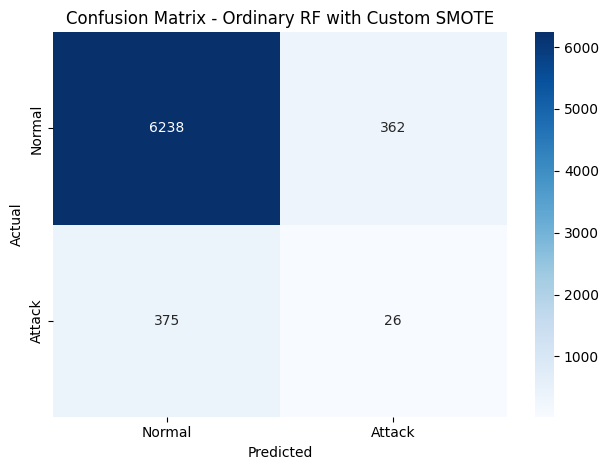

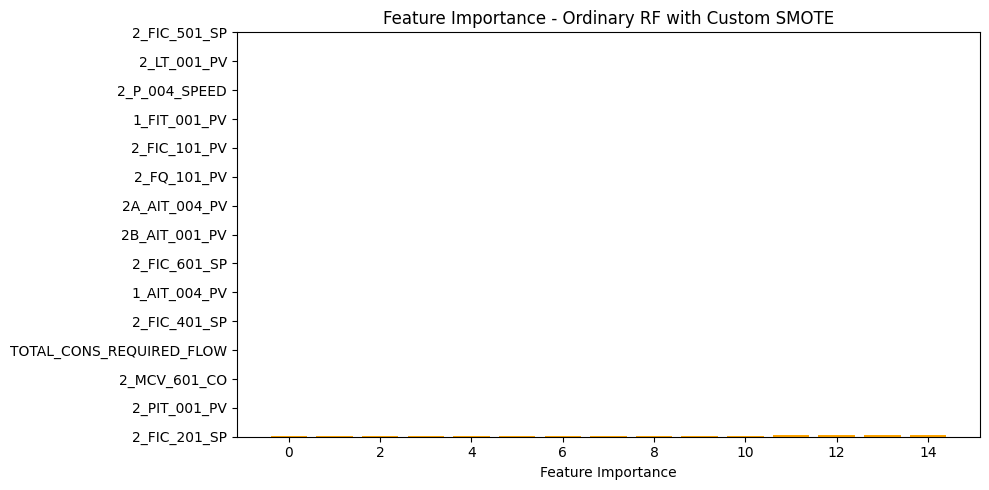

Model saved to smote_dropna_random_forest_model.pkl


In [21]:
# Ordinary model
rf_smote_basic = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_smote_basic.fit(X_train_smote, y_train_smote)

# Predict on original test set
y_pred_smote_basic = rf_smote_basic.predict(X_test_aligned)

# Evaluate
print("🔹 Ordinary RF with Custom SMOTE:")
print(classification_report(y_test_aligned, y_pred_smote_basic))
# Confusion Matrix
cm_smote_basic = confusion_matrix(y_test_aligned, y_pred_smote_basic, labels=[1, -1])
sns.heatmap(cm_smote_basic, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Ordinary RF with Custom SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Feature Importance
feature_importances_smote_basic = rf_smote_basic.feature_importances_
indices_smote_basic = np.argsort(feature_importances_smote_basic)[-15:]
plt.figure(figsize=(10, 5))
plt.bar(range(len(indices_smote_basic)), feature_importances_smote_basic[indices_smote_basic], color='orange', align='center')
plt.yticks(range(len(indices_smote_basic)), X_train_smote.columns[indices_smote_basic])
plt.xlabel('Feature Importance')
plt.title("Feature Importance - Ordinary RF with Custom SMOTE")
plt.tight_layout()
plt.show()
# Save the model
model_path_smote_basic = 'smote_dropna_random_forest_model.pkl'
joblib.dump(rf_smote_basic, model_path_smote_basic)
print(f"Model saved to {model_path_smote_basic}")


Fitting 2 folds for each of 8 candidates, totalling 16 fits
🔹 Tuned RF with Custom SMOTE:
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

        -1.0       0.07      0.06      0.07       401
         1.0       0.94      0.95      0.94      6600

    accuracy                           0.89      7001
   macro avg       0.51      0.50      0.51      7001
weighted avg       0.89      0.89      0.89      7001

[[  26  375]
 [ 362 6238]]


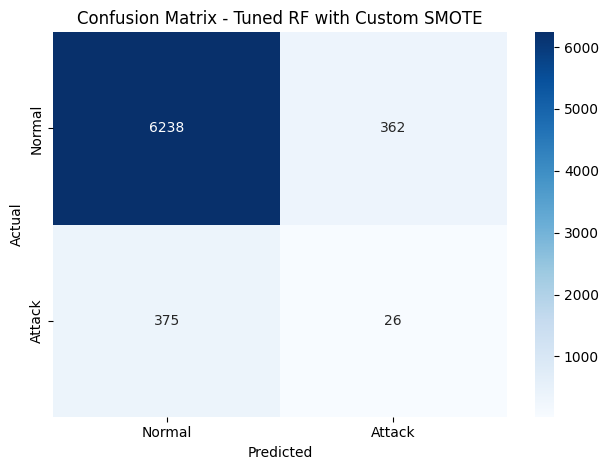

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

# Tuned model with GridSearch
rf_smote_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=2,            # Reduce CV folds for memory
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro'
)
rf_smote_grid.fit(X_train_smote, y_train_smote)

# Final model and predictions
best_rf_smote = rf_smote_grid.best_estimator_
y_pred_smote_tuned = best_rf_smote.predict(X_test_aligned)

print("🔹 Tuned RF with Custom SMOTE:")
print("Best Params:", rf_smote_grid.best_params_)
print(classification_report(y_test_aligned, y_pred_smote_tuned))
# Confusion Matrix
print(confusion_matrix(y_test_aligned, y_pred_smote_tuned))
cm_smote_tuned = confusion_matrix(y_test_aligned, y_pred_smote_tuned, labels=[1, -1])
sns.heatmap(cm_smote_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Tuned RF with Custom SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Feature Importance
feature_importances_smote_tuned = best_rf_smote.feature_importances_
plt.bar(X_train.columns, feature_importances_smote_tuned)
plt.title("Feature Importances - Tuned RF with Custom SMOTE")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()
# Save the model
model_path_smote_tuned = 'smote_tuneddropna_random_forest_model.pkl'
joblib.dump(best_rf_smote, model_path_smote_tuned)
print(f"Model saved to {model_path_smote_tuned}")

In [23]:
from sklearn.impute import SimpleImputer

# Rebuild X_test DataFrame
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Drop columns that were dropped from training
X_test_aligned = X_test_df.drop(columns=columns_to_drop, errors='ignore')

# Impute missing values using mean
imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test_aligned)

# Rebuild aligned y_test
y_test_series = pd.Series(y_test, index=X_test_df.index)
y_test_aligned = y_test_series.loc[X_test_aligned.index].reset_index(drop=True)
# Recheck: remove rows where labels are NaN
valid_indices = ~pd.isna(y_test_aligned)

# Final clean test set
X_test_imputed = X_test_imputed[valid_indices]
y_test_final = y_test_aligned[valid_indices]

# FINAL SHAPE CHECK
print("✅ X_test shape after imputation:", X_test_imputed.shape)

✅ X_test shape after imputation: (7001, 123)


c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


🔹 Ordinary RF with Custom SMOTE:
              precision    recall  f1-score   support

        -1.0       0.07      0.06      0.07       401
         1.0       0.94      0.95      0.94      6600

    accuracy                           0.89      7001
   macro avg       0.51      0.50      0.51      7001
weighted avg       0.89      0.89      0.89      7001



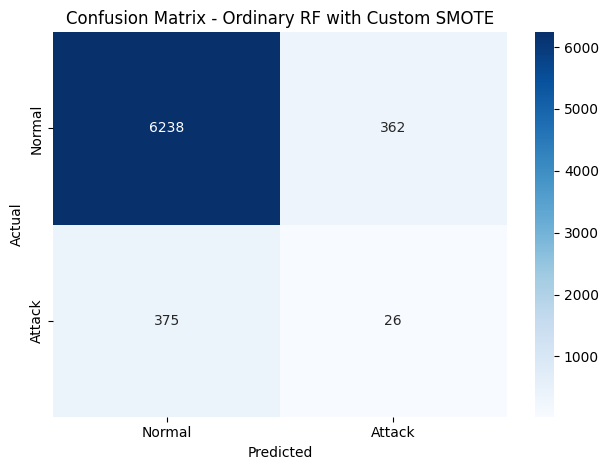

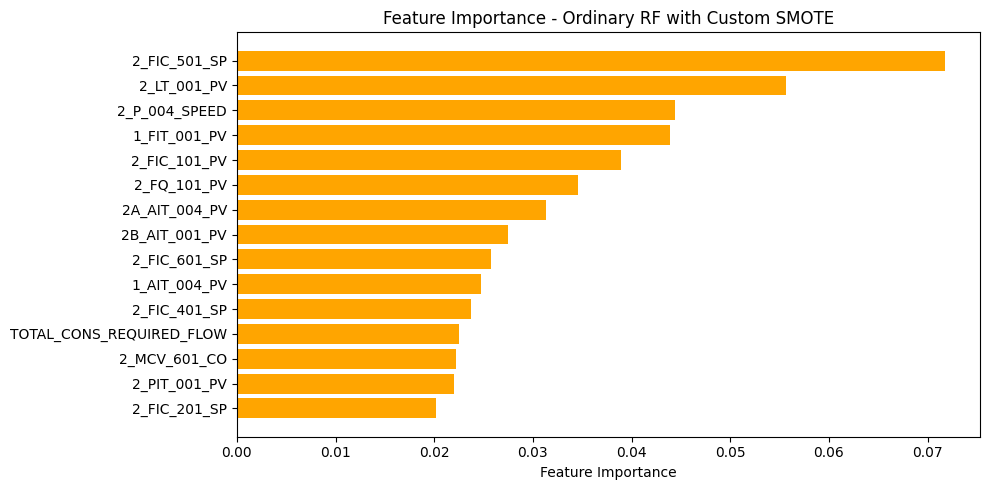

Model saved to smote_imputed_random_forest_model.pkl


In [24]:
# Ordinary model
rf_smote_basic = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_smote_basic.fit(X_train_smote, y_train_smote)

# Predict on original test set
y_pred_smote_basic = rf_smote_basic.predict(X_test_imputed)

# Evaluate
print("🔹 Ordinary RF with Custom SMOTE:")
print(classification_report(y_test_final, y_pred_smote_basic))
# Confusion Matrix
cm_smote_basic = confusion_matrix(y_test_final, y_pred_smote_basic, labels=[1, -1])
sns.heatmap(cm_smote_basic, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Ordinary RF with Custom SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Feature Importance
feature_importances_smote_basic = rf_smote_basic.feature_importances_
indices_smote_basic = np.argsort(feature_importances_smote_basic)[-15:]
plt.figure(figsize=(10, 5))
plt.barh(range(len(indices_smote_basic)), feature_importances_smote_basic[indices_smote_basic], color='orange', align='center')
plt.yticks(range(len(indices_smote_basic)), X_train_smote.columns[indices_smote_basic])
plt.xlabel('Feature Importance')
plt.title("Feature Importance - Ordinary RF with Custom SMOTE")
plt.tight_layout()
plt.show()
# Save the model
model_path_smote_basic = 'smote_imputed_random_forest_model.pkl'
joblib.dump(rf_smote_basic, model_path_smote_basic)
print(f"Model saved to {model_path_smote_basic}")


Fitting 2 folds for each of 8 candidates, totalling 16 fits


c:\Users\israila.dare\OneDrive - Eko Electricity Distribution PLC\Documents\GitHub\smartfactoriesim\wadi\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


🔹 Tuned RF with Custom SMOTE:
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

        -1.0       0.07      0.06      0.07       401
         1.0       0.94      0.95      0.94      6600

    accuracy                           0.89      7001
   macro avg       0.51      0.50      0.51      7001
weighted avg       0.89      0.89      0.89      7001

[[  26  375]
 [ 362 6238]]


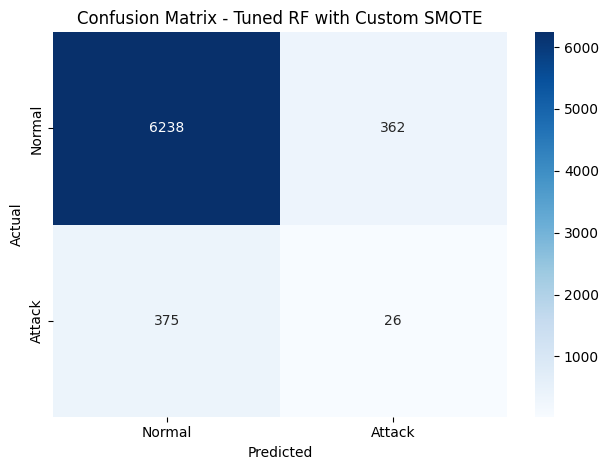

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

<Figure size 1000x500 with 0 Axes>

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

# Tuned model with GridSearch
rf_smote_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=2,            # Reduce CV folds for memory
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro'
)
rf_smote_grid.fit(X_train_smote, y_train_smote)

# Final model and predictions
best_rf_smote = rf_smote_grid.best_estimator_
y_pred_smote_tuned = best_rf_smote.predict(X_test_imputed)

print("🔹 Tuned RF with Custom SMOTE:")
print("Best Params:", rf_smote_grid.best_params_)
print(classification_report(y_test_final, y_pred_smote_tuned))
# Confusion Matrix
print(confusion_matrix(y_test_final, y_pred_smote_tuned))
cm_smote_tuned = confusion_matrix(y_test_final, y_pred_smote_tuned, labels=[1, -1])
sns.heatmap(cm_smote_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix - Tuned RF with Custom SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
# Feature Importance
feature_importances_smote_tuned = best_rf_smote.feature_importances_
plt.figure(figsize=(10, 5))
plt.barh(X_train.columns, feature_importances_smote_tuned)
plt.title("Feature Importances - Tuned RF with Custom SMOTE")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()
# Save the model
model_path_smote_tuned = 'smote_tunedimputed_random_forest_model.pkl'
joblib.dump(best_rf_smote, model_path_smote_tuned)
print(f"Model saved to {model_path_smote_tuned}")

In [26]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error
)
import pandas as pd

# Collect all predictions
model_results = {
    "Ordinary RF": y_pred_basic,
    "Tuned RF": y_pred_tuned,
    "Ordinary RF + SMOTE": y_pred_smote_basic,
    "Tuned RF + SMOTE": y_pred_smote_tuned
}

# Prepare performance storage
metrics = []

# Loop through models
for name, preds in model_results.items():
    metrics.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, pos_label=-1),
        "Recall": recall_score(y_test, preds, pos_label=-1),
        "F1 Score": f1_score(y_test, preds, pos_label=-1),
        "AUC": roc_auc_score((y_test == -1).astype(int), (preds == -1).astype(int)),
        "MSE": mean_squared_error(y_test, preds)
    })

# Create summary DataFrame
summary_df = pd.DataFrame(metrics).set_index("Model")
summary_df = summary_df.round(4)

# Display
print("📊 Model Performance Summary:")
print(summary_df)
# Save summary to CSV
summary_csv_path = 'model_performance_summary.csv'
summary_df.to_csv(summary_csv_path)
print(f"Model performance summary saved to {summary_csv_path}")

ValueError: Found input variables with inconsistent numbers of samples: [34561, 7001]

# Auto encoder
## Train only on normal data (label = 1)

### Reconstruct input; high reconstruction error = likely attack

### Evaluate using AUC, F1, precision, recall on the test set


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🔥 Using device:", device)
